Цель проекта:
отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

Задача проекта:
провести разведывательный анализ данных и составить отчёт по его результатам.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

In [74]:
df = pd.read_csv('stud_math.csv')

In [75]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

Столбцы содержат много пропусков, необходимо как то обработать, либо удалить значения, либо заменить средним, медианным значением, наиболее часто встречающимся.
Создаем формулу для заполнения пропусков в столбцах методом interpolation, method='pad'

In [62]:
def fill_by_interpolate (col):
    df[col].interpolate(method='pad',inplace=True)

Заполняем пропуски

In [63]:
for col in df.columns:
    fill_by_interpolate(col)


Создаем формулу для заполнения оставшихся пропусков mode

In [64]:
def fill_by_mode(col):
    df[col].fillna(df[col].mode()[0], inplace=True)

Заполняем ячейки mode

In [65]:
for col in df.columns:
    fill_by_mode(col)

После заполнения проверяем датафрейм на пропуски

In [8]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              395 non-null    object 
 4   famsize              395 non-null    object 
 5   Pstatus              395 non-null    object 
 6   Medu                 395 non-null    float64
 7   Fedu                 395 non-null    float64
 8   Mjob                 395 non-null    object 
 9   Fjob                 395 non-null    object 
 10  reason               395 non-null    object 
 11  guardian             395 non-null    object 
 12  traveltime           395 non-null    float64
 13  studytime            395 non-null    float64
 14  failures             395 non-null    float64
 15  schoolsup            395 non-null    obj

Все пропуски заполнены, можно приступать к более конкретному анализу по столбцам
Создаем и применяем формулу для просмотра всех не числовых столбцов

In [66]:
def info_obj_columns(obj_col):
    obj_info = df[obj_col].value_counts()
    print(obj_info)

In [67]:
obj_cols = df.select_dtypes(include = [np.object]).columns
for obj_col in obj_cols:
    info_obj_columns(obj_col)

F    208
M    187
Name: sex, dtype: int64
U    304
R     91
Name: address, dtype: int64
course        146
reputation    108
home          105
other          36
Name: reason, dtype: int64
yes    374
no      21
Name: higher, dtype: int64
no     260
yes    135
Name: romantic, dtype: int64
<ipython-input-67-871221ff7e9b>:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  obj_cols = df.select_dtypes(include = [np.object]).columns


Не числовые столбцы на данный момент не нуждаются в дальнейшей обработке
Создаем фоормулу для определения границ выбросов

In [68]:
def outliers (num_col):
    IQR = df[num_col].quantile(0.75) - df[num_col].quantile(0.25)
    perc25 = df[num_col].quantile(0.25)
    perc75 = df[num_col].quantile(0.75)
    f = perc25 - 1.5*IQR
    l = perc75 + 1.5*IQR
    print(
    '25-й перцентиль: {},'.format(perc25),
    '75-й перцентиль: {},'.format(perc75),
    "IQR: {}, ".format(IQR),
    "Границы выбросов: [{},{}]".format(f, l))

Создаем фоормулу для замены выбросов на mode

In [69]:
def fill_outliers(num_col):
    IQR = df[num_col].quantile(0.75) - df[num_col].quantile(0.25)
    perc25 = df[num_col].quantile(0.25)
    perc75 = df[num_col].quantile(0.75)
    f = perc25 - 1.5*IQR
    l = perc75 + 1.5*IQR
    mode_col = df[num_col].mode()[0]
    df[num_col] = df[num_col].apply(
        lambda x: mode_col if x > l or x < f else x)

## Анализ и преобразование числовых столбцов

In [13]:
num_cols = df.select_dtypes(exclude = [np.object]).columns
num_cols

<ipython-input-13-1c3705ebe27c>:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_cols = df.select_dtypes(exclude = [np.object]).columns


Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
       'studytime, granular', 'famrel', 'freetime', 'goout', 'health',
       'absences', 'score'],
      dtype='object')

## Column 'age'

Строим гистограмму распределения значений столбца 'age'

<AxesSubplot:xlabel='age', ylabel='count'>

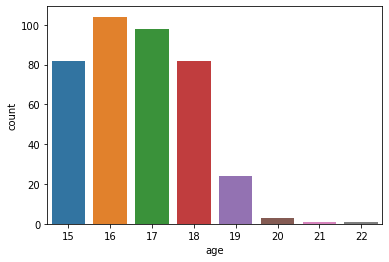

In [14]:
sns.countplot(x = df['age'], data = df)

In [15]:
df.age.value_counts()

16    104
17     98
15     82
18     82
19     24
20      3
21      1
22      1
Name: age, dtype: int64

Данный столбец выбросов не содержит

## Column 'Medu'


В этом столбце содержиться информация об образовании матери
(0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

<AxesSubplot:xlabel='Medu', ylabel='count'>

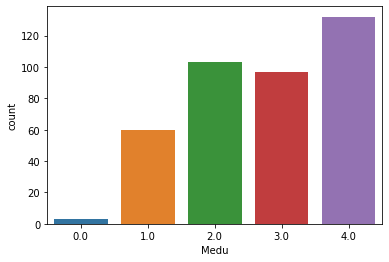

In [16]:
sns.countplot(x = df['Medu'], data = df)

In [17]:
df.Medu.value_counts()

4.0    132
2.0    103
3.0     97
1.0     60
0.0      3
Name: Medu, dtype: int64

Выбросы отсутствуют

## Column 'Fedu'

В этом столбце содержиться информация об образовании отца
(0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

<AxesSubplot:xlabel='Fedu', ylabel='count'>

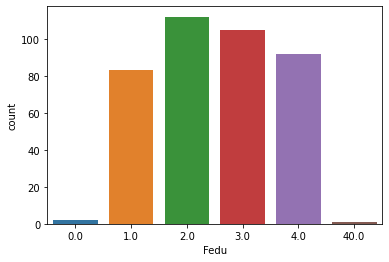

In [18]:
sns.countplot(x = df['Fedu'], data = df)

In [19]:
df.Fedu.value_counts()

2.0     112
3.0     105
4.0      92
1.0      83
0.0       2
40.0      1
Name: Fedu, dtype: int64

Имеется одно не корректное значение 40, которое является выбросом возможно была опечатка и вместо 4 внесли в файл 40. Заменим значение на 4

In [20]:
df.loc[df['Fedu'] == 40,'Fedu'] = 4

In [21]:
df.Fedu.value_counts()

2.0    112
3.0    105
4.0     93
1.0     83
0.0      2
Name: Fedu, dtype: int64

## Column 'traveltime'

В этом столбце содержиться информация о времени, которое тратиться на дорогу до школы
(1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

<AxesSubplot:xlabel='traveltime', ylabel='count'>

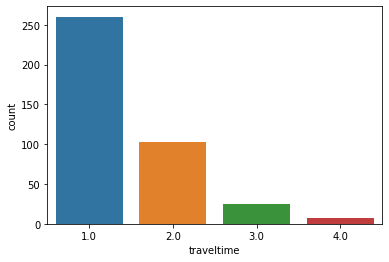

In [22]:
sns.countplot(x = df['traveltime'], data = df)

In [23]:
df.traveltime.value_counts()

1.0    260
2.0    103
3.0     25
4.0      7
Name: traveltime, dtype: int64

Выбросы отсутствуют

## Column 'studytime'

В данном столбце содержиться информация о времени, которое тратиться на учёбу помимо школы в неделю
(1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

<AxesSubplot:xlabel='studytime', ylabel='count'>

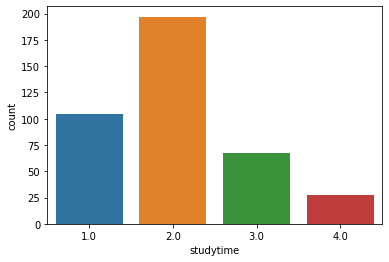

In [24]:
sns.countplot(x = df['studytime'], data = df)

Выбросов отсутствуют

## Column 'failures'

Данный столбец показвает количество внеучебных неудач
(n, если 1<=n<=3, иначе 0)

<AxesSubplot:xlabel='failures', ylabel='count'>

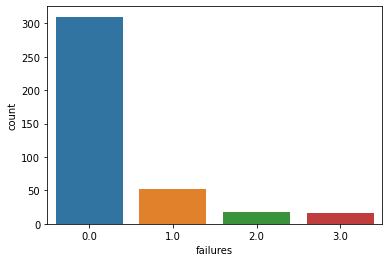

In [25]:
sns.countplot(x = df['failures'], data = df)

In [26]:
df.failures.value_counts()

0.0    310
1.0     52
2.0     17
3.0     16
Name: failures, dtype: int64

Выбросы отсутствуют

## Column 'studytime, granular'

Не понятно пока что это за колонка и какие данные в ней содержатся, т.к. в описани к DataSet она не упоминается. Оставляем пока как есть. 

<AxesSubplot:xlabel='studytime, granular', ylabel='count'>

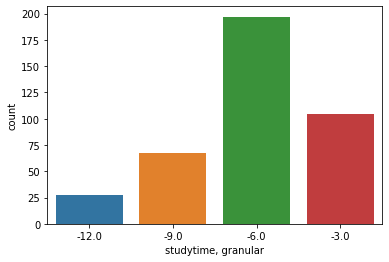

In [28]:
sns.countplot(x = df['studytime, granular'], data = df)

## Column 'famrel'

В этом столбце содержится информация о семейных отношенияй
(от 1 - очень плохо до 5 - очень хорошо)

<AxesSubplot:xlabel='famrel', ylabel='count'>

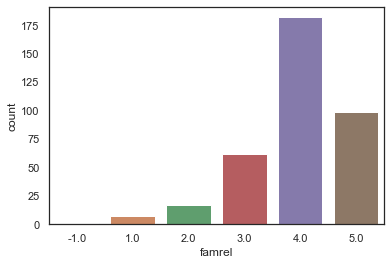

In [76]:
sns.countplot(x = df['famrel'], data = df)

In [30]:
df.famrel.value_counts()

 4.0    192
 5.0    110
 3.0     68
 2.0     17
 1.0      7
-1.0      1
Name: famrel, dtype: int64

В данном столбце присутствует отризательное значение -1, также скорей всего произошли опечатка и имелось ввиду значение 1. Поменяем это значение на 1.

In [31]:
df.loc[df['famrel'] == -1,'famrel'] = 1

In [32]:
df.famrel.unique()

array([4., 5., 3., 1., 2.])

## Column 'freetime'


Данная колонка отражает свободное время после школы
от 1 - очень мало до 5 - очень мого

<AxesSubplot:xlabel='freetime', ylabel='count'>

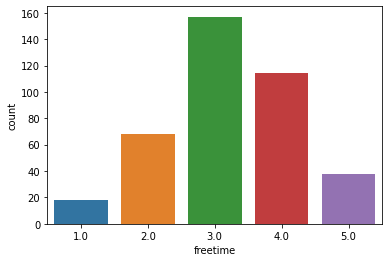

In [33]:
sns.countplot(x = df.freetime, data = df)

Выбросы отсутствуют

## Column 'goout'

Данная коллонка показывает время проведенное с друзьями
от 1 - очень мало до 5 - очень много

<AxesSubplot:xlabel='goout', ylabel='count'>

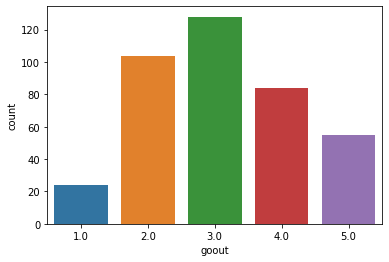

In [34]:
sns.countplot(x = df.goout, data = df)

Выбросы отсутствуют

## Column 'health'

в данном столбце описано текущее состояние здоровья
от 1 - очень плохо до 5 - очень хорошо

<AxesSubplot:xlabel='health', ylabel='count'>

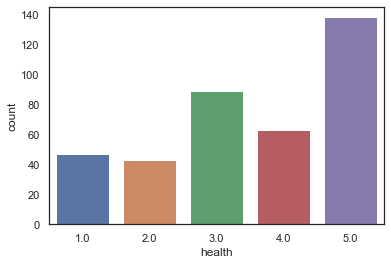

In [77]:
sns.countplot(x = df.health, data = df)

Выбросы отсутствуют

## Column 'absences'

В данном столбце содержиться информация о количестве пропущенных занятий

In [78]:
df.absences.value_counts()

0.0      111
2.0       60
4.0       53
6.0       31
8.0       21
10.0      17
14.0      12
12.0      12
3.0        8
16.0       7
7.0        6
18.0       5
5.0        5
20.0       4
9.0        3
22.0       3
1.0        3
13.0       2
15.0       2
11.0       2
40.0       1
38.0       1
56.0       1
23.0       1
24.0       1
25.0       1
385.0      1
17.0       1
75.0       1
21.0       1
212.0      1
28.0       1
19.0       1
26.0       1
30.0       1
54.0       1
Name: absences, dtype: int64

Определяем границы выбросов

In [79]:
outliers ('absences')

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0,20.0]


Применяем формулу, которая заменяет выбросы на моду

In [80]:
fill_outliers('absences')

Проверяем значения

In [81]:
df.absences.value_counts()

0.0     128
2.0      60
4.0      53
6.0      31
8.0      21
10.0     17
12.0     12
14.0     12
3.0       8
16.0      7
7.0       6
18.0      5
5.0       5
20.0      4
1.0       3
9.0       3
11.0      2
15.0      2
13.0      2
19.0      1
17.0      1
Name: absences, dtype: int64

Строим гистограмму для просмотра получившихся данных и их распределения.

(array([128.,   3.,  60.,   8.,  53.,   5.,  31.,   6.,  21.,   3.,  17.,
          2.,  12.,   2.,  12.,   2.,   7.,   1.,   5.,   5.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20.]),
 <BarContainer object of 20 artists>)

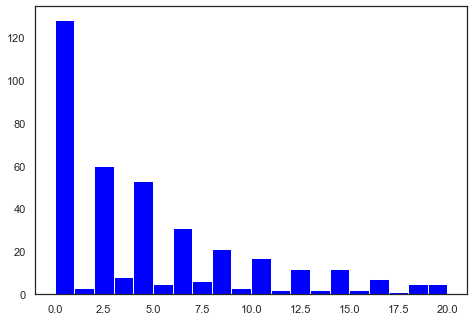

In [83]:

fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.hist(df['absences'], bins = 20, color = 'blue')

## Column 'score'
В данном столбце содержиться информация о баллах по госэкзамену по математике

In [84]:
df.score.value_counts()

50.0     54
55.0     46
0.0      37
75.0     33
65.0     31
60.0     31
40.0     31
45.0     27
70.0     27
80.0     16
30.0     15
90.0     12
35.0      9
25.0      7
85.0      6
95.0      5
20.0      1
100.0     1
Name: score, dtype: int64

Строим гистограмму распределения оценок

(array([38.,  0.,  0.,  0.,  1.,  7., 15.,  9., 31., 27., 54., 46., 33.,
        33., 27., 33., 17.,  6., 12.,  6.]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.]),
 <BarContainer object of 20 artists>)

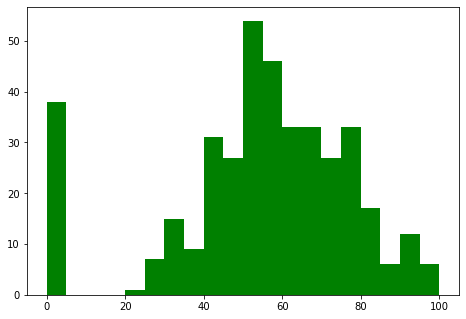

In [43]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.hist(df['score'], bins = 20, color = 'green')

Выбросы отсутстуют

## Корреляция признаков

In [44]:
df_corr = df.corr()

Матрица корреляций

<AxesSubplot:title={'center':'Covariance Matrix'}>

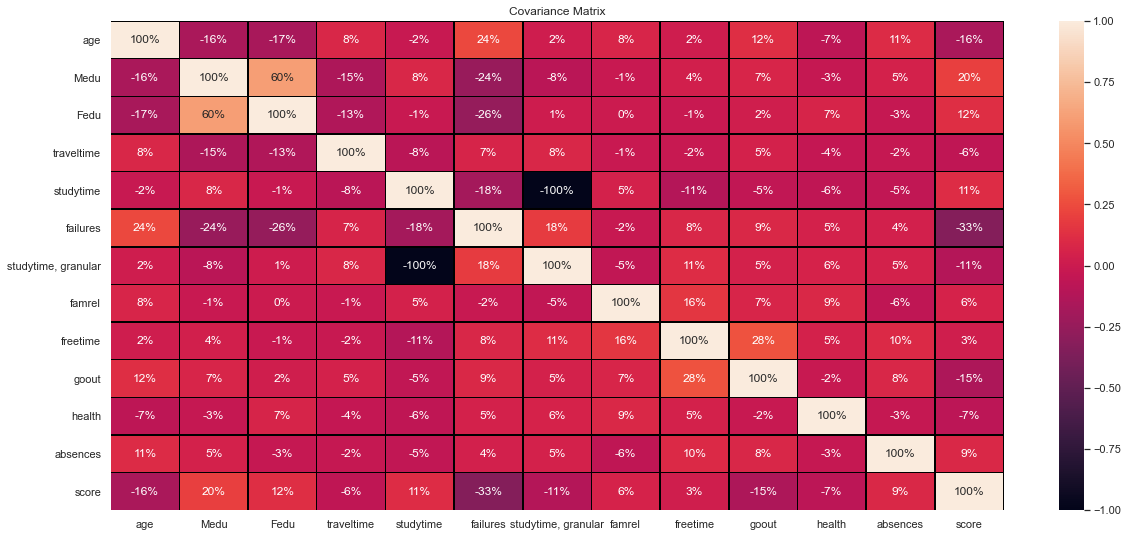

In [45]:
sns.set(style='white')
plt.figure(figsize=(20, 9))
plt.title('Covariance Matrix')
sns.heatmap(df_corr, mask=df_corr.isnull(), annot=True,
            fmt='.0%', linewidths=0.5, linecolor='black')

Столбец 'studytime, granular' сильно скоррелирован со столбцом studytime, так как мы не знаем что это за столбец, можем его удалить 

In [85]:
df_corr = df.loc[:, [x for x in df_corr.columns if x != 'studytime, granular' ]].corr()

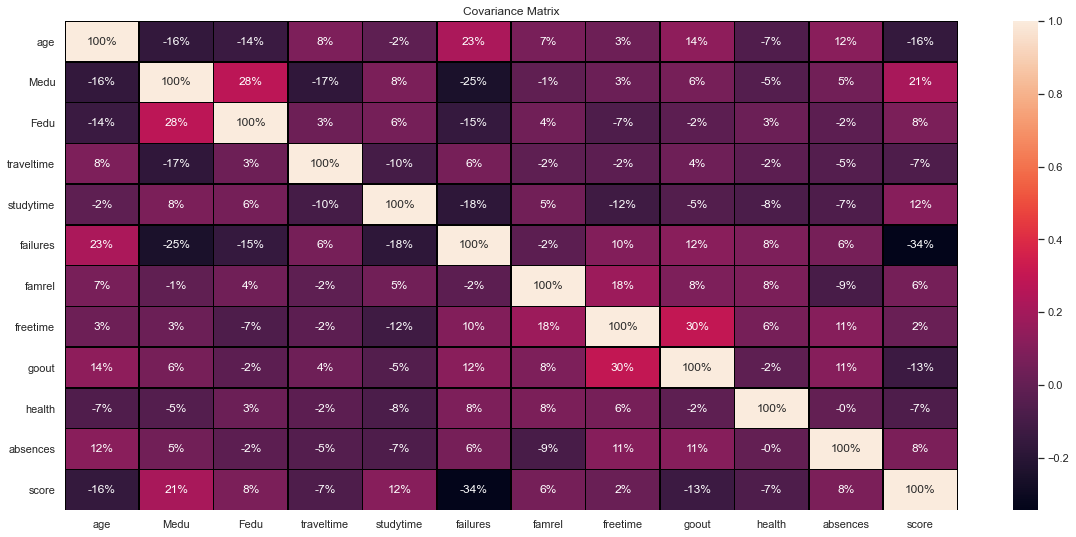

In [86]:
sns.set(style='white')
plt.figure(figsize=(20, 9))
plt.title('Covariance Matrix')
sns.heatmap(df_corr, mask=df_corr.isnull(), annot=True, fmt='.0%', linewidths=0.5, linecolor='black');


Из этой матрицы корреляций нельзя сделать вывод о сильном влиянии какого-то одного признака на значение score, но несколько переменных хоть и слабо но корелируют, это: age, Medu, Fedu, studytime, failures и goout. Для дальнешего анализа оставим только эти числовые столбцы.

Пишем функцию для создания боксплотов


In [48]:
def get_boxplot(obj_col):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x = obj_col , y='score', 
                data = df,
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + obj_col)
    plt.show()

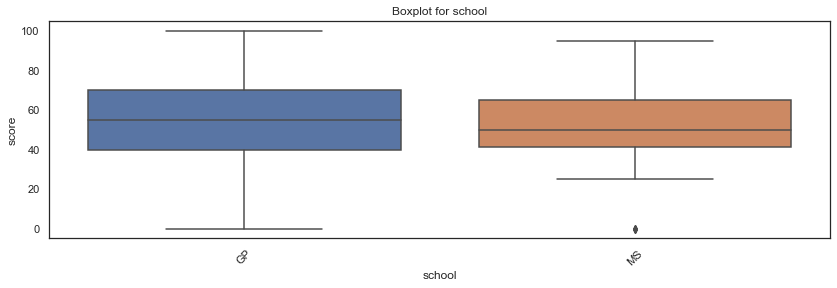

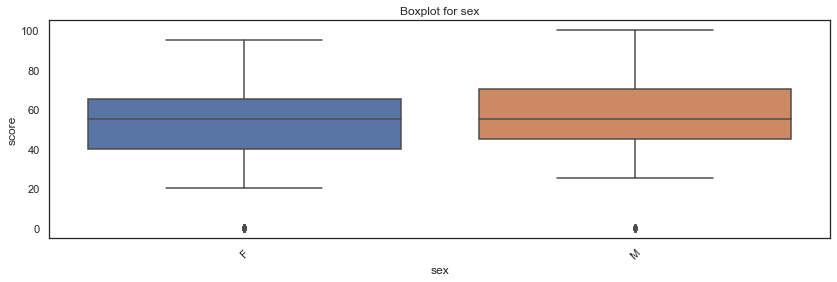

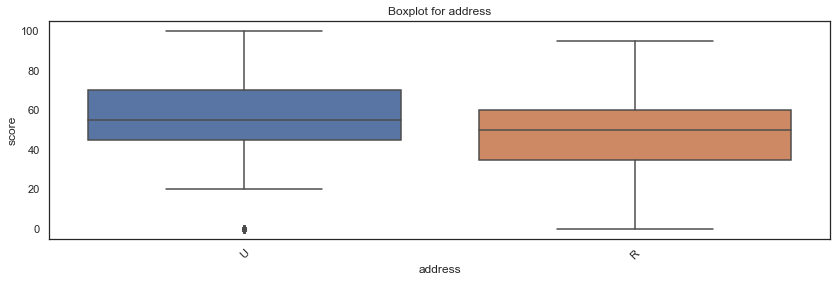

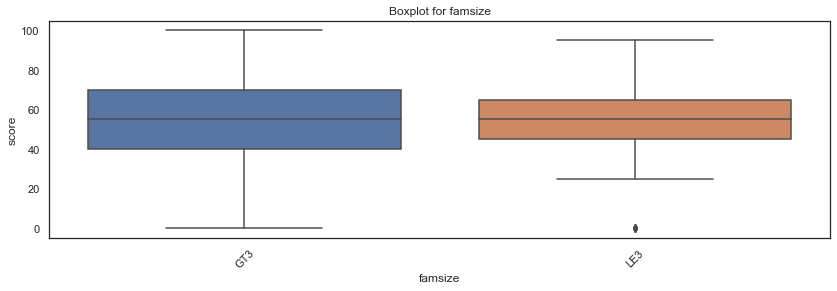

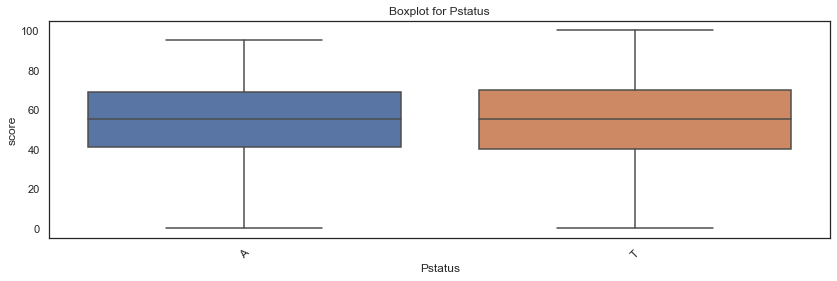

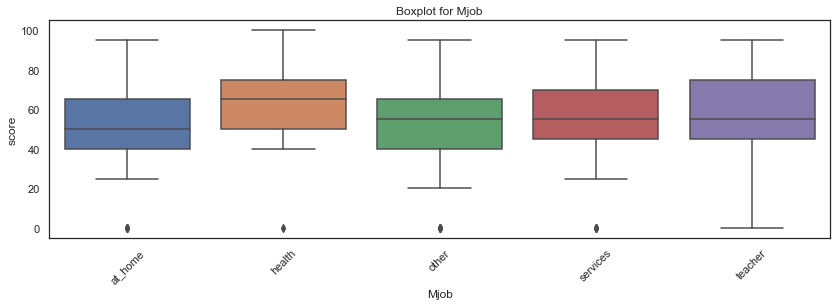

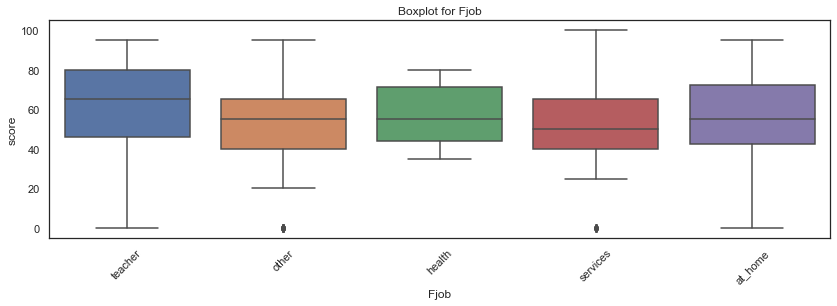

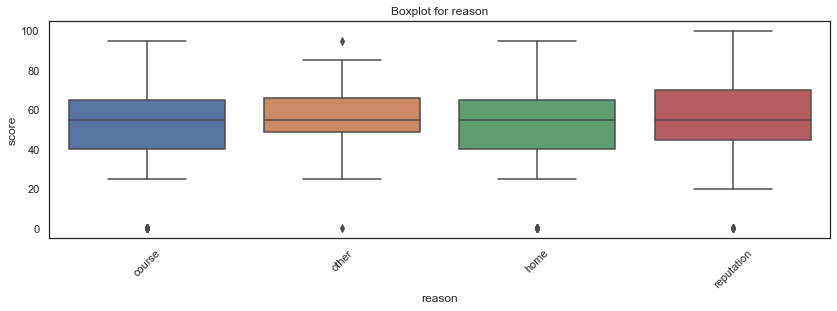

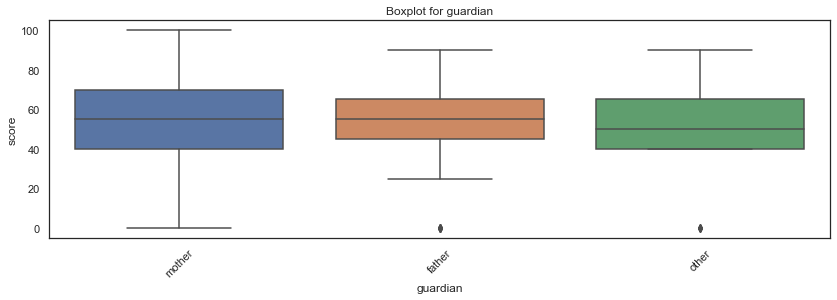

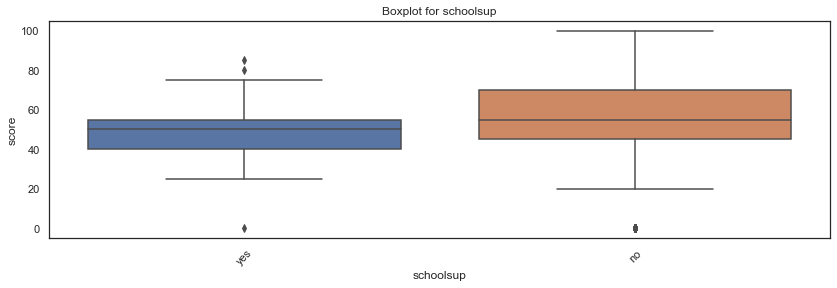

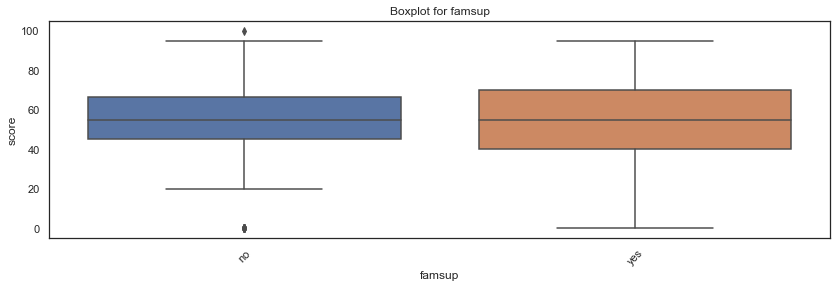

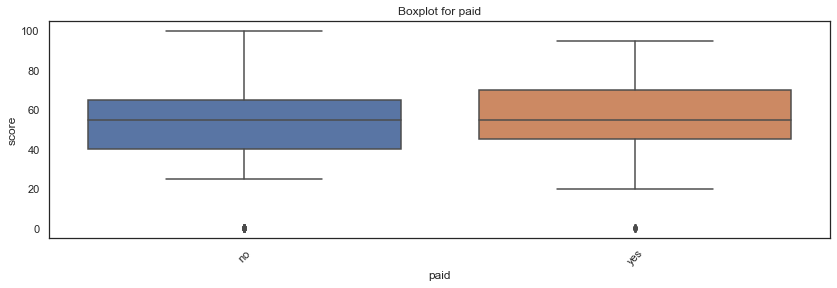

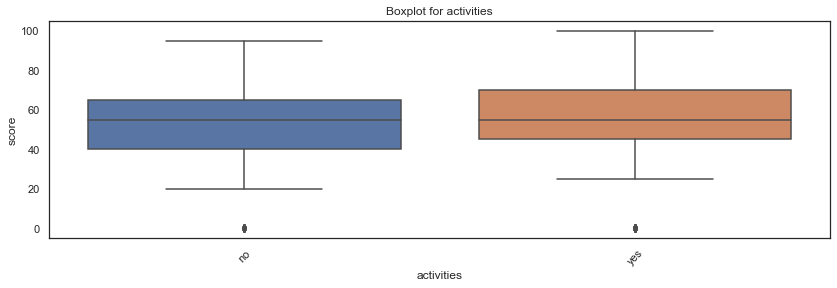

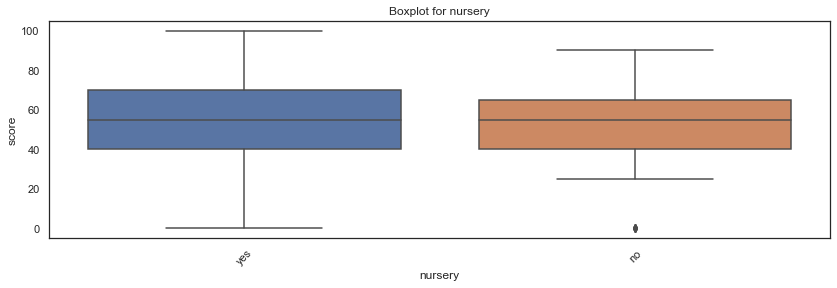

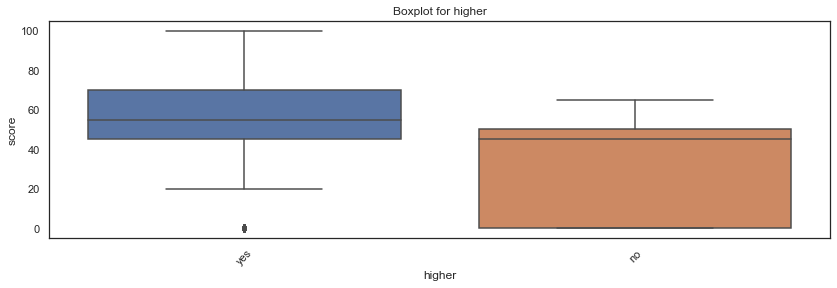

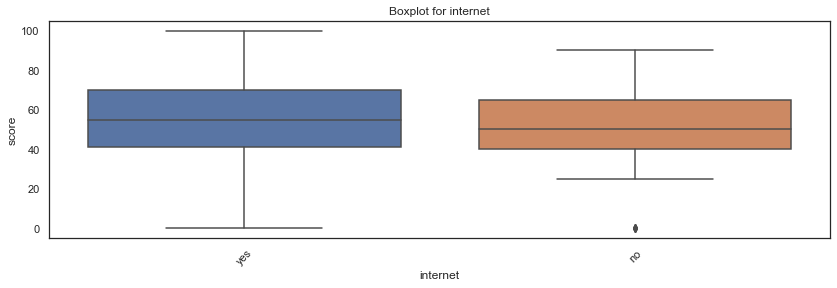

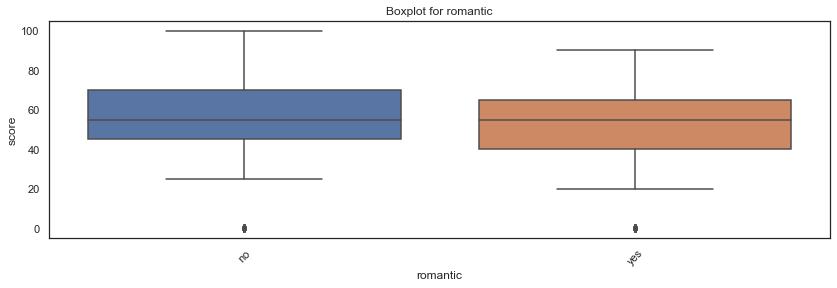

In [49]:
for obj_col in obj_cols:
    get_boxplot(obj_col)

По боксплотам видны различия в столбцах adress, Mjob, Fjob, higher и schoolsup, проверим значимы ли статистически эти различия при помощи ttest

In [50]:

def get_stat_dif(obj_col):
    cols = df.loc[:, obj_col].value_counts().index[:2]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, obj_col] == comb[0], 'score'], 
                        df.loc[df.loc[:, obj_col] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', obj_col)
            break

In [51]:
for obj_col in obj_cols:
    get_stat_dif(obj_col)

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки reason
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic


Составляем итоговый датафрейм из числовых столбцов показавших корреляцию выше 10% и не числовых столбцов у которых найдены статистически значимые различия.

In [52]:
col_list = ['sex','address','reason', 'higher', 'romantic','age',
                         'Medu', 'Fedu','studytime', 'failures',
                         'goout','score']

In [55]:
df = df[col_list]
df

,sex,address,reason,higher,romantic,age,Medu,Fedu,studytime,failures,goout,score
0,F,U,course,yes,no,18,4.0,4.0,2.0,0.0,4.0,30.0
1,F,U,course,yes,no,17,1.0,1.0,2.0,0.0,3.0,30.0
2,F,U,other,yes,no,15,1.0,1.0,2.0,3.0,2.0,50.0
3,F,U,home,yes,yes,15,4.0,2.0,3.0,0.0,2.0,75.0
4,F,U,home,yes,no,16,3.0,3.0,2.0,0.0,2.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...
390,M,U,course,yes,no,20,2.0,2.0,2.0,2.0,4.0,45.0
391,M,U,course,yes,no,17,3.0,1.0,1.0,0.0,5.0,80.0
392,M,R,course,yes,no,21,1.0,1.0,1.0,3.0,3.0,35.0
393,M,R,course,yes,no,18,3.0,2.0,1.0,0.0,1.0,50.0


## Выводы:
из 30 столбцов в исходном датасете, а финальный вошли только 12, то есть только 11 признаков оказывают существенное влияние на переменную score